In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
import umap.umap_ as umap


In [2]:
df = pd.read_csv('./Book1.csv', sep=';')

In [3]:
df

,UKMcode,No,Cluster,Aspirin user,Group,Centre,StudyPhase,StudyPhase.1,Aspirin user.1,Intervention_code,...,CONCEPTION,Prev_Preg,Preg_Interval,MAge_EDD,MAP_MOM_CENTRE,UTAPI_MOM_Centre,PLGF_MOM_Centre,logMAPMoM,logPIMoM,logPIGFMoM
0,HNH-4300,1,6.0,Non intervention_NO Aspirin,Observation_High risk,Hanoi Obstetrics & Gynecology Hospital,7.0,OBSERVATION,Non intervention_High risk,NaN,...,SPONTANEOUS,NULLIP,NaN,"28,2518","1,165","1,1135","0,2163","0,066325925","0,046690221","-0,664943481"
1,HNH-4340,2,6.0,Non intervention_NO Aspirin,Observation_High risk,Hanoi Obstetrics & Gynecology Hospital,7.0,OBSERVATION,Non intervention_High risk,NaN,...,SPONTANEOUS,NULLIP,NaN,"26,9185","1,2844","1,0061","3,146","0,108700297","0,002641149","0,497758718"
2,HNH-4465,3,6.0,Non intervention_NO Aspirin,Observation_High risk,Hanoi Obstetrics & Gynecology Hospital,7.0,OBSERVATION,Non intervention_High risk,NaN,...,SPONTANEOUS,NULLIP,NaN,"27,5098","1,3369","0,9543","0,4072","0,126098923","-0,020315076","-0,390192231"
3,HNH-4878,4,6.0,Non intervention_NO Aspirin,Observation_Low risk,Hanoi Obstetrics & Gynecology Hospital,7.0,OBSERVATION,Non intervention_Low risk,NaN,...,SPONTANEOUS,MULTIP-NO PE,"6,92","31,9424","0,9049","1,393","0,1188","-0,043399412","0,143951116","-0,925183559"
4,HNH-5219,5,6.0,Non intervention_NO Aspirin,Observation_High risk,Hanoi Obstetrics & Gynecology Hospital,7.0,OBSERVATION,Non intervention_High risk,NaN,...,SPONTANEOUS,NULLIP,NaN,"25,0814","1,2384","0,9861","0,4393","0,092860943","-0,006079041","-0,357238797"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,U000380586,1076,NaN,NaN,NaN,MEDISCAN,NaN,validation,Validation_no aspirin,NaN,...,Spontaneous,Nullip,0,"27,3045859","1,127380654","0,821641909","1,428884308",NaN,NaN,NaN
1076,U000226877,1077,NaN,NaN,NaN,MEDISCAN,NaN,validation,Validation_no aspirin,NaN,...,Spontaneous,Multip-no PE,"6,56","36,82956879","1,153207668","0,791411037","1,535347817",NaN,NaN,NaN
1077,U000194812,1078,NaN,NaN,NaN,MEDISCAN,NaN,validation,Validation_no aspirin,NaN,...,Spontaneous,Multip-no PE,"7,62","34,83641342","1,029363279","1,147981152","0,992454587",NaN,NaN,NaN
1078,URA-001,1079,NaN,NaN,NaN,CRIFM PMC,NaN,validation,Validation_no aspirin,NaN,...,Spontaneous,Nullip,0,"39,3402","0,952627811","0,92791185","1,001086984",NaN,NaN,NaN


In [4]:
df.dropna(subset='Intervention_code', axis=0, inplace=True)
# All the rest have preeclampsia:
# 1 received aspirin, 0 didn’t receive it. They represent our two groups.

In [5]:
df.columns

Index(['UKMcode', 'No', 'Cluster', 'Aspirin user', 'Group', 'Centre',
       'StudyPhase', 'StudyPhase.1', 'Aspirin user.1', 'Intervention_code',
       'Studyphase_code', 'Aspirin_Code', 'AdjOdds_PE_LT37_Centre',
       'GestDeliveryWks', 'Gaweek', 'intervaltreatmenttodel',
       'PregPET_Eclampsia', 'GA at PE diagnosis', 'onset PE week',
       'interval_onsettodel', 'GRAVIDA', 'PARITY', 'DOB', 'HEIGHT', 'WEIGHT',
       'ETHNICITY', 'CHRONIC_HT', 'SLE/APS', 'DMTYPE1', 'DMTYPE2',
       'INSULINUSER', 'PREVHXPE', 'FAMHXPE', 'SMOKER', 'CONCEPTION',
       'Prev_Preg', 'Preg_Interval', 'MAge_EDD', 'MAP_MOM_CENTRE',
       'UTAPI_MOM_Centre', 'PLGF_MOM_Centre', 'logMAPMoM', 'logPIMoM',
       'logPIGFMoM'],
      dtype='object')

- AdjOdds_PE_LT37_Centre (Risk for developing PE, 1:xxx)
- GestDeliveryWks (gestational age at delivery) 
- intervaltreatmenttodel (please ignore) 
- GRAVIDA (number of pregnancies she got) 
- PARITY (number of livebirth before) 
- DOB (date of  birth) 
- CHRONIC_HT (chronic hypertention) 
- SLE/APS (antiphospholipid syndrome) 
- DMTYPE1 (diabetes type 1) 
- DMTYPE2 (diabetes type 2) 
- MAP_MOM_CENTRE (Mean artery pressure MoM)
- UTAPI_MOM_Centre (Utrerine artery PI MoM) 
- PLGF_MOM_Centre (PlGF MoM)
- logMAPMoM,logPIMoM,logPIGFMoM (just log transformation of the previous MoM)

In [6]:
df['StudyPhase.1'].value_counts()

StudyPhase.1
INTERVENTION    344
Name: count, dtype: int64

In [7]:
df['StudyPhase'].value_counts()

StudyPhase
2.0    344
Name: count, dtype: int64

In [8]:
df['Studyphase_code'].value_counts()

Studyphase_code
3    344
Name: count, dtype: int64

In [9]:
df['Group'].value_counts()

Group
Intervention_high risk    344
Name: count, dtype: int64

In [10]:
df['No'].value_counts()

No
9      1
657    1
671    1
667    1
666    1
      ..
316    1
313    1
312    1
311    1
856    1
Name: count, Length: 344, dtype: int64

In [11]:
df['Aspirin user.1'].value_counts()

Aspirin user.1
Intervention_high risk_Aspirin       280
Intervention_High risk_NO Aspirin     60
Intervention_High risk_No Aspirin      3
Intervention_high risk_No Aspirin      1
Name: count, dtype: int64

In [12]:
val_counts = {}
val_counts['feature'] = df.columns
val_counts['counts'] = [df[c].value_counts().shape[0] for c in df.columns]
    
val_counts = pd.DataFrame(val_counts)
val_counts

,feature,counts
0,UKMcode,344
1,No,344
2,Cluster,7
3,Aspirin user,2
4,Group,1
5,Centre,16
6,StudyPhase,1
7,StudyPhase.1,1
8,Aspirin user.1,4
9,Intervention_code,2


In [13]:
features_to_drop = val_counts[(val_counts['counts'] == 1) | (val_counts['counts'] == 344)]['feature']
df.drop(features_to_drop, axis=1, inplace=True)

In [14]:
df

,Cluster,Aspirin user,Centre,Aspirin user.1,Intervention_code,Aspirin_Code,AdjOdds_PE_LT37_Centre,GestDeliveryWks,Gaweek,intervaltreatmenttodel,...,CONCEPTION,Prev_Preg,Preg_Interval,MAge_EDD,MAP_MOM_CENTRE,UTAPI_MOM_Centre,PLGF_MOM_Centre,logMAPMoM,logPIMoM,logPIGFMoM
8,6.0,Intervention_high risk_Aspirin,Hanoi Obstetrics & Gynecology Hospital,Intervention_high risk_Aspirin,1.0,2,72,231,33,17,...,SPONTANEOUS,NULLIP,NaN,"19,9807","1,0423","1,1713","0,5462","0,017992738","0,068668143","-0,262648304"
12,6.0,Intervention_high risk_Aspirin,Hanoi Obstetrics & Gynecology Hospital,Intervention_high risk_Aspirin,1.0,2,61,270,38,22,...,SPONTANEOUS,NULLIP,NaN,"32,512","1,0017","1,731","0,6739","0,000737674","0,238297068","-0,171404544"
13,6.0,Intervention_high risk_Aspirin,Hanoi Obstetrics & Gynecology Hospital,Intervention_high risk_Aspirin,1.0,2,37,289,41,25,...,SPONTANEOUS,NULLIP,NaN,"26,4421","1,048","1,3636","0,4203","0,020361283","0,134686993","-0,37644061"
14,6.0,Intervention_high risk_Aspirin,Hanoi Obstetrics & Gynecology Hospital,Intervention_high risk_Aspirin,1.0,2,82,249,35,19,...,SPONTANEOUS,NULLIP,NaN,"30,6419","1,2227","0,6335","0,5187","0,087319912","-0,198253381","-0,285083752"
15,6.0,Intervention_high risk_Aspirin,Hanoi Obstetrics & Gynecology Hospital,Intervention_high risk_Aspirin,1.0,2,7,254,36,20,...,SPONTANEOUS,NULLIP,NaN,"25,2649","1,4362","0,9253","0,5744","0,157214922","-0,033717438","-0,240785569"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,5.0,Intervention_High risk_NO Aspirin,Harapan Kita Hospital,Intervention_High risk_NO Aspirin,0.0,1,5,268,38,22,...,SPONTANEOUS,NULLIP,NaN,"31,2389","1,1765","1,6995","1,0392","0,070591932","0,230321169","0,016699138"
852,5.0,Intervention_High risk_NO Aspirin,Harapan Kita Hospital,Intervention_High risk_NO Aspirin,0.0,1,50,263,37,21,...,IVF,NULLIP,NaN,"32,9637","1,1313","1,1157","0,9588","0,053577787","0,047547433","-0,018271975"
853,5.0,Intervention_High risk_NO Aspirin,Harapan Kita Hospital,Intervention_High risk_NO Aspirin,0.0,1,26,256,36,20,...,SPONTANEOUS,MULTIP-NO PE,"5,23","35,4825","1,1454","0,7024","1,4084","0,058957179","-0,153415497","0,148726016"
854,5.0,Intervention_High risk_NO Aspirin,Harapan Kita Hospital,Intervention_High risk_NO Aspirin,0.0,1,56,264,37,21,...,SPONTANEOUS,NULLIP,NaN,"40,2162","1,0623","1,3515","1,0526","0,026247181","0,13081605","0,022263366"


In [15]:
for c in ['MAP_MOM_CENTRE', 'UTAPI_MOM_Centre', 'PLGF_MOM_Centre', 'logMAPMoM', 'logPIMoM', 'logPIGFMoM']:
    df[c] = [float(x.replace(',', '.')) for x in df[c]]

In [16]:
df

,Cluster,Aspirin user,Centre,Aspirin user.1,Intervention_code,Aspirin_Code,AdjOdds_PE_LT37_Centre,GestDeliveryWks,Gaweek,intervaltreatmenttodel,...,CONCEPTION,Prev_Preg,Preg_Interval,MAge_EDD,MAP_MOM_CENTRE,UTAPI_MOM_Centre,PLGF_MOM_Centre,logMAPMoM,logPIMoM,logPIGFMoM
8,6.0,Intervention_high risk_Aspirin,Hanoi Obstetrics & Gynecology Hospital,Intervention_high risk_Aspirin,1.0,2,72,231,33,17,...,SPONTANEOUS,NULLIP,NaN,"19,9807",1.0423,1.1713,0.5462,0.017993,0.068668,-0.262648
12,6.0,Intervention_high risk_Aspirin,Hanoi Obstetrics & Gynecology Hospital,Intervention_high risk_Aspirin,1.0,2,61,270,38,22,...,SPONTANEOUS,NULLIP,NaN,"32,512",1.0017,1.7310,0.6739,0.000738,0.238297,-0.171405
13,6.0,Intervention_high risk_Aspirin,Hanoi Obstetrics & Gynecology Hospital,Intervention_high risk_Aspirin,1.0,2,37,289,41,25,...,SPONTANEOUS,NULLIP,NaN,"26,4421",1.0480,1.3636,0.4203,0.020361,0.134687,-0.376441
14,6.0,Intervention_high risk_Aspirin,Hanoi Obstetrics & Gynecology Hospital,Intervention_high risk_Aspirin,1.0,2,82,249,35,19,...,SPONTANEOUS,NULLIP,NaN,"30,6419",1.2227,0.6335,0.5187,0.087320,-0.198253,-0.285084
15,6.0,Intervention_high risk_Aspirin,Hanoi Obstetrics & Gynecology Hospital,Intervention_high risk_Aspirin,1.0,2,7,254,36,20,...,SPONTANEOUS,NULLIP,NaN,"25,2649",1.4362,0.9253,0.5744,0.157215,-0.033717,-0.240786
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,5.0,Intervention_High risk_NO Aspirin,Harapan Kita Hospital,Intervention_High risk_NO Aspirin,0.0,1,5,268,38,22,...,SPONTANEOUS,NULLIP,NaN,"31,2389",1.1765,1.6995,1.0392,0.070592,0.230321,0.016699
852,5.0,Intervention_High risk_NO Aspirin,Harapan Kita Hospital,Intervention_High risk_NO Aspirin,0.0,1,50,263,37,21,...,IVF,NULLIP,NaN,"32,9637",1.1313,1.1157,0.9588,0.053578,0.047547,-0.018272
853,5.0,Intervention_High risk_NO Aspirin,Harapan Kita Hospital,Intervention_High risk_NO Aspirin,0.0,1,26,256,36,20,...,SPONTANEOUS,MULTIP-NO PE,"5,23","35,4825",1.1454,0.7024,1.4084,0.058957,-0.153415,0.148726
854,5.0,Intervention_High risk_NO Aspirin,Harapan Kita Hospital,Intervention_High risk_NO Aspirin,0.0,1,56,264,37,21,...,SPONTANEOUS,NULLIP,NaN,"40,2162",1.0623,1.3515,1.0526,0.026247,0.130816,0.022263


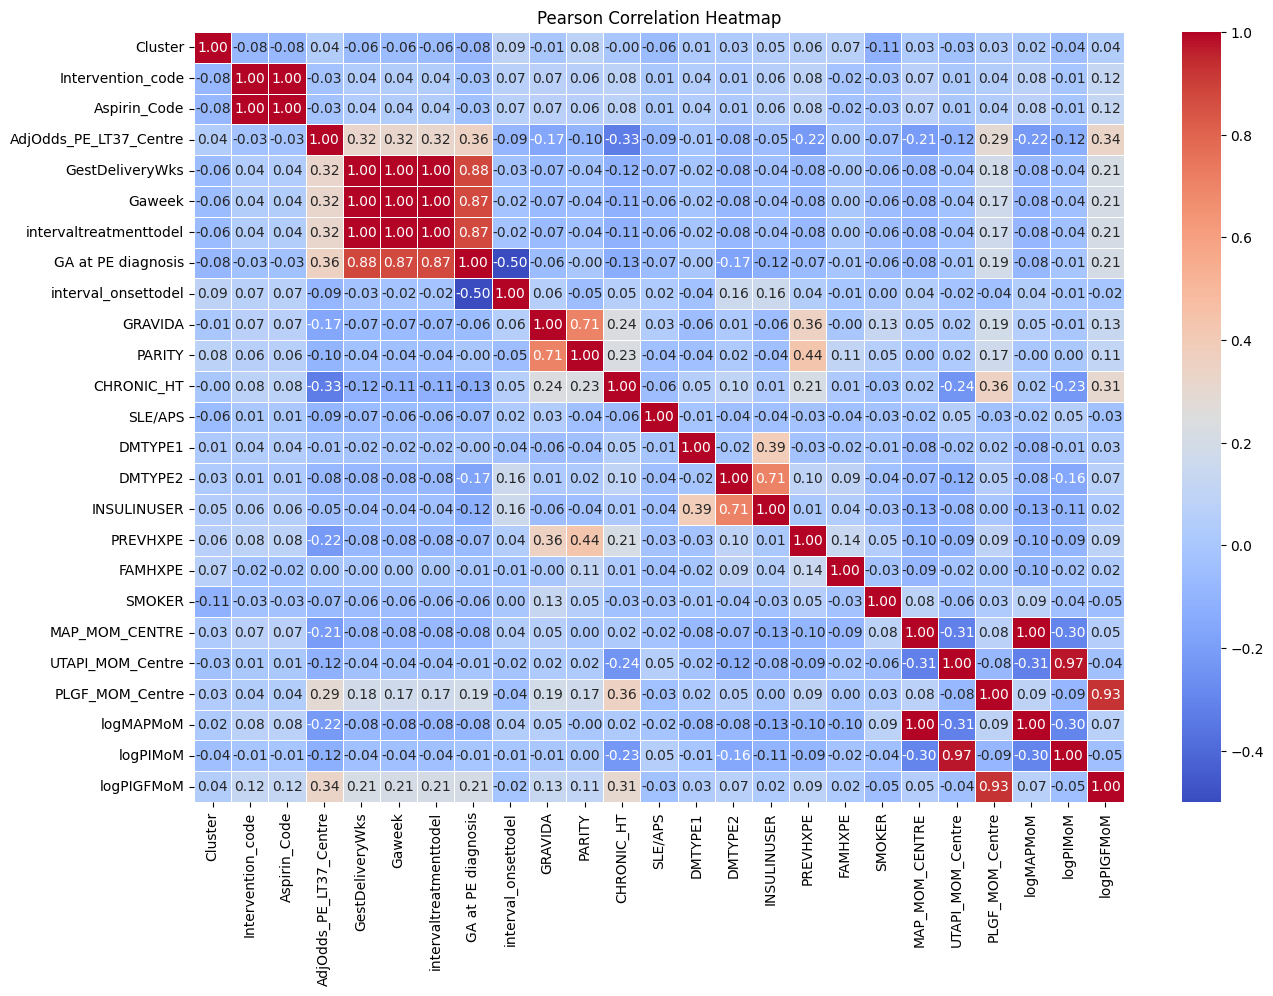

In [17]:
correlation_matrix = df.select_dtypes(include=[np.number]).corr()

plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Pearson Correlation Heatmap')
plt.show()

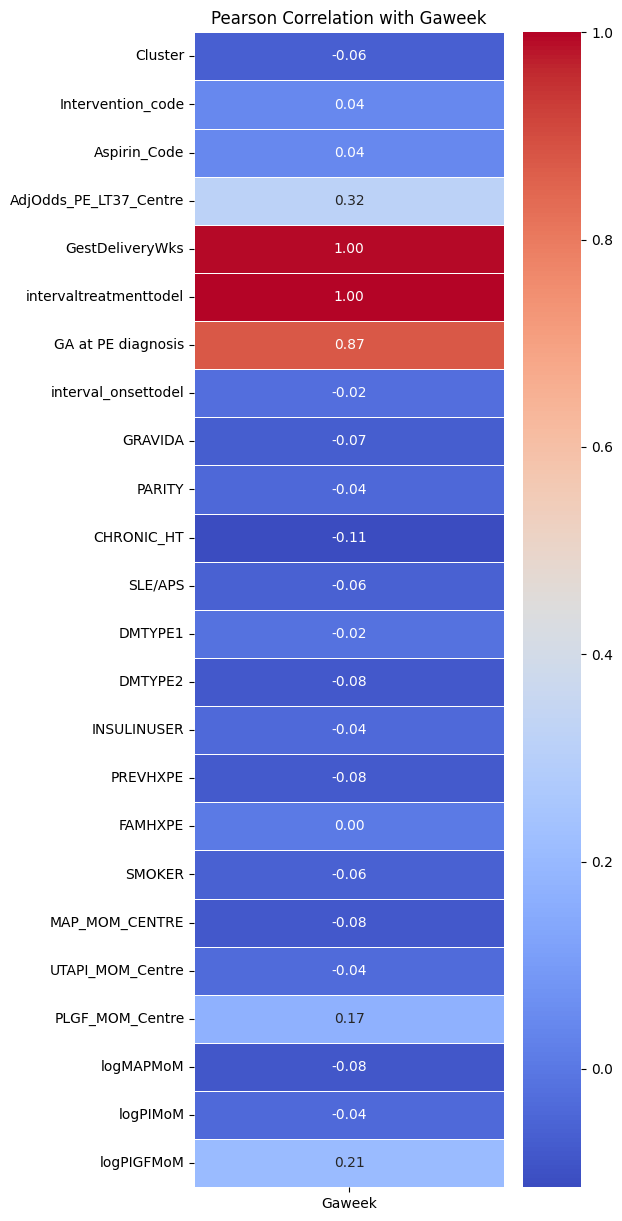

In [18]:
correlation = df.select_dtypes(include=[np.number]).corr()[['Gaweek']].drop('Gaweek')

plt.figure(figsize=(5, len(correlation) * 0.5 + 3))  # Adjust height dynamically
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title(f'Pearson Correlation with Gaweek')
plt.show()

In [19]:
columns_of_interest = ['Gaweek','Intervention_code', 'AdjOdds_PE_LT37_Centre', 'CHRONIC_HT', 'MAP_MOM_CENTRE', 'UTAPI_MOM_Centre', 'PLGF_MOM_Centre', 'logMAPMoM', 'logPIMoM', 'logPIGFMoM', 'SLE/APS', 'DMTYPE1', 'DMTYPE2']
# columns_of_interest = ['Gaweek','Intervention_code', 'AdjOdds_PE_LT37_Centre', 'CHRONIC_HT' , 'PLGF_MOM_Centre']

In [20]:
df[columns_of_interest]

,Gaweek,Intervention_code,AdjOdds_PE_LT37_Centre,CHRONIC_HT,MAP_MOM_CENTRE,UTAPI_MOM_Centre,PLGF_MOM_Centre,logMAPMoM,logPIMoM,logPIGFMoM,SLE/APS,DMTYPE1,DMTYPE2
8,33,1.0,72,0,1.0423,1.1713,0.5462,0.017993,0.068668,-0.262648,0,0,0.0
12,38,1.0,61,0,1.0017,1.7310,0.6739,0.000738,0.238297,-0.171405,0,0,0.0
13,41,1.0,37,0,1.0480,1.3636,0.4203,0.020361,0.134687,-0.376441,0,0,0.0
14,35,1.0,82,0,1.2227,0.6335,0.5187,0.087320,-0.198253,-0.285084,0,0,0.0
15,36,1.0,7,0,1.4362,0.9253,0.5744,0.157215,-0.033717,-0.240786,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
851,38,0.0,5,1,1.1765,1.6995,1.0392,0.070592,0.230321,0.016699,0,0,0.0
852,37,0.0,50,0,1.1313,1.1157,0.9588,0.053578,0.047547,-0.018272,0,0,0.0
853,36,0.0,26,1,1.1454,0.7024,1.4084,0.058957,-0.153415,0.148726,0,0,0.0
854,37,0.0,56,0,1.0623,1.3515,1.0526,0.026247,0.130816,0.022263,0,0,0.0


In [21]:
umap_model = umap.UMAP()
umap_result = umap_model.fit_transform(df[columns_of_interest])

In [22]:
df['Centre'].unique()

array(['Hanoi Obstetrics & Gynecology Hospital',
       'National University Hospital', 'Nanjing Drum Tower Hospital',
       'Angel Women & Children Hospital ', 'Chang Gung Hospital',
       'Taiji Clinic', 'Chulalongkorn University Hospital',
       'Siriraj Hospital', 'Maharaj Nakorn Chiang Mai Hospital',
       'Thammasat University Hospital', 'Harapan Kita Hospital',
       'Prince of Wales Hospital',
       'Pusat Perubatan Universiti Kebangsaan ',
       'Showa University Hospital (JSSHP)', 'JSSHP and CRIFM',
       'Guangzhou'], dtype=object)

In [23]:
batches = list(df["Centre"].unique())
batches_dict = {k:v for v, k in enumerate(batches)}
batches_dict

{'Hanoi Obstetrics & Gynecology Hospital': 0,
 'National University Hospital': 1,
 'Nanjing Drum Tower Hospital': 2,
 'Angel Women & Children Hospital ': 3,
 'Chang Gung Hospital': 4,
 'Taiji Clinic': 5,
 'Chulalongkorn University Hospital': 6,
 'Siriraj Hospital': 7,
 'Maharaj Nakorn Chiang Mai Hospital': 8,
 'Thammasat University Hospital': 9,
 'Harapan Kita Hospital': 10,
 'Prince of Wales Hospital': 11,
 'Pusat Perubatan Universiti Kebangsaan ': 12,
 'Showa University Hospital (JSSHP)': 13,
 'JSSHP and CRIFM': 14,
 'Guangzhou': 15}

<Axes: >

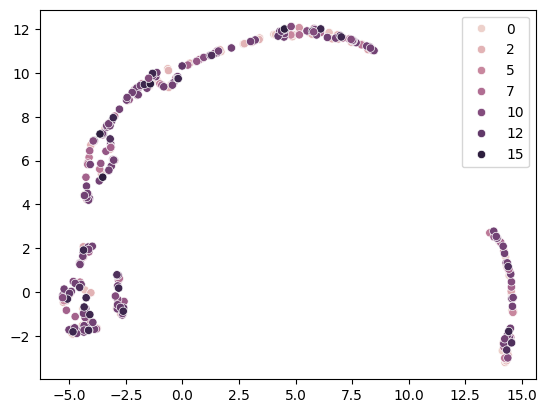

In [24]:
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=df['Centre'].apply(lambda x: batches_dict[x]).values)

### Model training

In [25]:
from pyopls import OPLS
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, KFold
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Intervention_code: 1 received aspirin, 0 didn’t receive it. They represent our two groups.

In [26]:
df['Intervention_code'].value_counts()

Intervention_code
1.0    280
0.0     64
Name: count, dtype: int64

In [27]:
# Train on non-aspirin data

# X = df[df['Intervention_code'] == 0][columns_of_interest]
# asa = df[df['Intervention_code'] == 1][columns_of_interest]
# y = X['Gaweek']
# X.drop(['Gaweek', 'Intervention_code'], axis=1, inplace=True)

In [28]:
# Train on aspirin data

X = df[df['Intervention_code'] == 1][columns_of_interest]
non_asa = df[df['Intervention_code'] == 0][columns_of_interest]
y = X['Gaweek']
X.drop(['Gaweek', 'Intervention_code'], axis=1, inplace=True)

In [29]:
X

,AdjOdds_PE_LT37_Centre,CHRONIC_HT,MAP_MOM_CENTRE,UTAPI_MOM_Centre,PLGF_MOM_Centre,logMAPMoM,logPIMoM,logPIGFMoM,SLE/APS,DMTYPE1,DMTYPE2
8,72,0,1.0423,1.1713,0.5462,0.017993,0.068668,-0.262648,0,0,0.0
12,61,0,1.0017,1.7310,0.6739,0.000738,0.238297,-0.171405,0,0,0.0
13,37,0,1.0480,1.3636,0.4203,0.020361,0.134687,-0.376441,0,0,0.0
14,82,0,1.2227,0.6335,0.5187,0.087320,-0.198253,-0.285084,0,0,0.0
15,7,0,1.4362,0.9253,0.5744,0.157215,-0.033717,-0.240786,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
834,5,1,1.2735,1.0880,1.0076,0.104999,0.036629,0.003288,0,0,0.0
838,20,0,1.0200,0.8855,0.2732,0.008600,-0.052811,-0.563519,0,0,0.0
839,2,1,1.1360,1.1496,0.6727,0.055378,0.060547,-0.172179,0,0,0.0
846,18,1,1.1294,0.7480,0.9730,0.052848,-0.126098,-0.011887,0,0,0.0


In [30]:
y

8      33
12     38
13     41
14     35
15     36
       ..
834    34
838    38
839    38
846    38
847    37
Name: Gaweek, Length: 280, dtype: int64

In [31]:
def mean_error(y_true, y_pred):
    return np.mean(y_true - y_pred)

mean_error_scorer = make_scorer(mean_error, greater_is_better=False)
mean_absolute_error_scorer = make_scorer(mean_absolute_error, greater_is_better=True)
mean_squared_error_scorer = make_scorer(mean_squared_error, greater_is_better=True)
r2_scorer = make_scorer(r2_score)

# nested cross validation
def get_best_params_reg(pipeline, params, X, y):
    
    grid = GridSearchCV(pipeline, param_grid=params, cv=KFold(n_splits=5, shuffle=True, random_state=7), 
                        scoring='neg_mean_squared_error', n_jobs=-1)

    cv = KFold(n_splits=5, shuffle=True, random_state=7)
    scoring = {
        'mean_error': mean_error_scorer,
        'mean_absolute_error': mean_absolute_error_scorer,
        'mean_squared_error': mean_squared_error_scorer,
        'r2': r2_scorer
    }
    
    scores = cross_validate(grid, X, y, scoring=scoring, cv=cv, n_jobs=-1)
    
    grid.fit(X, y)
    best_params = grid.best_params_

    return scores, best_params 

In [32]:
# pipe = Pipeline([
#     ('scaler', StandardScaler()), 
#     ('regressor', XGBRegressor(objective='reg:squarederror'))
# ])

# params = {
#     'regressor__n_estimators': [100, 200, 300],
#     'regressor__max_depth': [5, 7, 10],
#     'regressor__learning_rate': [0.001, 0.01, 0.1],
# #     'regressor__reg_alpha': [0, 0.01, 0.1, 1, 10],
# #     'regressor__reg_lambda': [0.01, 0.1, 1, 10, 100],
# #     'regressor__gamma': [0, 0.01, 0.1, 1, 10]
# }


In [43]:
models = {
    "XGB": XGBRegressor(objective="reg:squarederror"),
    "RandomForest": RandomForestRegressor(),
    "Ridge": Ridge()
}

params = [
    {
        'regressor': [XGBRegressor(objective='reg:squarederror')],
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [5, 10, 15],
        'regressor__learning_rate': [0.01, 0.1, 1],
#         'regressor__reg_alpha': [0, 0.01, 0.1, 1, 10],
#         'regressor__reg_lambda': [0.01, 0.1, 1, 10, 100],
#         'regressor__gamma': [0, 0.01, 0.1, 1, 10]
    },
    {
        'regressor': [RandomForestRegressor()],
        'regressor__n_estimators': [100, 200, 300],
        'regressor__max_depth': [5, 10, None],
        'regressor__min_samples_split': [2, 5, 10],
        'regressor__min_samples_leaf': [1, 2, 4]
    },
    {
        'regressor': [Ridge()],
        'regressor__alpha': [0.01, 0.1, 1, 10, 100]
    }
]

pipe = Pipeline([
    ('scaler', StandardScaler()), 
    ('regressor', XGBRegressor(objective='reg:squarederror')) 
])


In [44]:
scores, best_params = get_best_params_reg(pipe, params, X, y)

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
/home/lucija/.local/lib/python3.10/site-packages/xgboost/data.py:440: FutureWarning: is_sparse is deprecated

In [45]:
print(scores)

for k, v in scores.items():
    print(k, np.mean(v))
    
print(best_params)

{'fit_time': array([412.69155216, 410.47982287, 410.98104715, 412.3853209 ,
       412.76855636]), 'score_time': array([0.02738857, 0.03028822, 0.05091119, 0.01772881, 0.01573181]), 'test_mean_error': array([-0.40834764,  0.67090486,  0.20128033, -0.36675641, -0.02423547]), 'test_mean_absolute_error': array([1.80930137, 1.93243459, 1.73732488, 2.02445591, 2.13229809]), 'test_mean_squared_error': array([5.44240333, 8.57397078, 6.35098322, 7.60259484, 7.69597385]), 'test_r2': array([-0.05988802,  0.1291627 ,  0.13791787,  0.06737062,  0.16373618])}
fit_time 411.86125988960265
score_time 0.028409719467163086
test_mean_error 0.014569133168292652
test_mean_absolute_error 1.9271629685471534
test_mean_squared_error 7.133185201521665
test_r2 0.08765987036346226
{'regressor': RandomForestRegressor(), 'regressor__max_depth': 5, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 5, 'regressor__n_estimators': 300}


In [46]:
y.min()

24

In [47]:
y.max()

41